In [1]:
# 1. IMPORT LIBRARY
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Untuk TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, models

# Untuk PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
class DataManager:
    """Mengelola pemuatan, prapemrosesan, dan penyediaan data untuk model."""
    def __init__(self, file_path, sample_frac=0.1, test_size=0.2, random_state=42):
        self.random_state = random_state
        self.y_scaler = StandardScaler()
        self._load_and_clean_data(file_path)
        self._preprocess_features()
        self._sample_and_split_data(sample_frac, test_size)
        self._scale_target()

    def _load_and_clean_data(self, file_path):
        """Memuat data dan melakukan pembersihan awal."""
        df = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False)
        df = df.apply(pd.to_numeric, errors='ignore')
        
        # Identifikasi target dan fitur
        int_cols = df.select_dtypes(include='int').columns
        self.target_column = int_cols[0] if len(int_cols) > 0 else df.select_dtypes(include=np.number).columns[0]
        self.X = df.drop(columns=[self.target_column])
        self.y = df[self.target_column]

        # Isi nilai NaN
        for col in self.X.select_dtypes(include=np.number).columns:
            self.X[col] = self.X[col].fillna(self.X[col].mean())
        for col in self.X.select_dtypes(include='object').columns:
            self.X[col] = self.X[col].fillna(self.X[col].mode()[0])
        
        self.y = self.y.dropna()
        self.X = self.X.loc[self.y.index]

    def _preprocess_features(self):
        """Menerapkan ColumnTransformer untuk penskalaan dan encoding."""
        cat_cols = self.X.select_dtypes(include='object').columns
        num_cols = self.X.select_dtypes(include=np.number).columns
        preprocessor = ColumnTransformer([
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ])
        self.X_processed = preprocessor.fit_transform(self.X)
        if hasattr(self.X_processed, 'toarray'):
            self.X_processed = self.X_processed.toarray()

    def _sample_and_split_data(self, sample_frac, test_size):
        """Mengambil sampel data dan membaginya menjadi set latih & uji."""
        X_small = self.X_processed[:int(sample_frac * self.X_processed.shape[0])]
        y_small = self.y.iloc[:X_small.shape[0]]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_small, y_small, test_size=test_size, random_state=self.random_state
        )

    def _scale_target(self):
        """Melakukan penskalaan pada variabel target."""
        self.y_train_scaled = self.y_scaler.fit_transform(self.y_train.values.reshape(-1, 1))
        self.y_test_scaled = self.y_scaler.transform(self.y_test.values.reshape(-1, 1))

    def get_data(self, framework='tf'):
        """Menyediakan data dalam format yang sesuai (numpy array atau tensor)."""
        if framework == 'torch':
            return (
                torch.tensor(self.X_train, dtype=torch.float32),
                torch.tensor(self.X_test, dtype=torch.float32),
                torch.tensor(self.y_train_scaled, dtype=torch.float32),
                torch.tensor(self.y_test_scaled, dtype=torch.float32),
            )
        return self.X_train, self.X_test, self.y_train_scaled, self.y_test_scaled

In [3]:
def plot_training_history(history_tf, history_pt, epochs_pt):
    """Membuat plot perbandingan riwayat training loss."""
    plt.figure(figsize=(10, 6))
    plt.plot(history_tf.history['loss'], label='TensorFlow Train Loss', color='blue')
    plt.plot(history_tf.history['val_loss'], label='TensorFlow Val Loss', color='cyan', linestyle='--')
    plt.plot(range(epochs_pt), history_pt['train_loss'], label='PyTorch Train Loss', color='purple')
    plt.plot(range(epochs_pt), history_pt['val_loss'], label='PyTorch Val Loss', color='magenta', linestyle='--')
    plt.title('Perbandingan Training & Validation Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_actual_vs_predicted(eval_results):
    """Membuat scatter plot perbandingan nilai aktual vs prediksi."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True, sharex=True)
    
    for i, (name, data) in enumerate(eval_results.items()):
        ax[i].scatter(data['y_true'], data['y_pred'], alpha=0.5, label=f'R² = {data["r2"]:.4f}')
        ax[i].plot([data['y_true'].min(), data['y_true'].max()], [data['y_true'].min(), data['y_true'].max()], 'r--', lw=2, label='Garis Ideal')
        ax[i].set_title(f'Aktual vs. Prediksi - {name}')
        ax[i].set_xlabel('Nilai Aktual')
        ax[i].set_ylabel('Nilai Prediksi')
        ax[i].legend()
        ax[i].grid(True)
    
    plt.suptitle('Perbandingan Kualitas Prediksi Model', fontsize=16)
    plt.show()

def plot_residuals(eval_results):
    """Membuat plot residual untuk analisis kesalahan model."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    
    for i, (name, data) in enumerate(eval_results.items()):
        residuals = data['y_true'] - data['y_pred'].flatten()
        ax[i].scatter(data['y_pred'], residuals, alpha=0.5)
        ax[i].axhline(y=0, color='r', linestyle='--')
        ax[i].set_title(f'Plot Residual - {name}')
        ax[i].set_xlabel('Nilai Prediksi')
        ax[i].set_ylabel('Residual (Aktual - Prediksi)')
        ax[i].grid(True)
        
    plt.suptitle('Analisis Kesalahan (Residual) Model', fontsize=16)
    plt.show()

In [4]:
class MLPTensorFlow:
    """Membangun, melatih, dan mengevaluasi model MLP dengan TensorFlow."""
    def __init__(self, input_dim):
        self.model = self._build_model(input_dim)

    def _build_model(self, input_dim):
        model = tf.keras.Sequential([
            layers.Dense(128, activation='relu', input_dim=input_dim),
            layers.BatchNormalization(), layers.Dropout(0.3),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(), layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def train(self, X_train, y_train_scaled, epochs=100, batch_size=64):
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(X_train, y_train_scaled, validation_split=0.2,
                                 epochs=epochs, batch_size=batch_size, callbacks=[early_stop], verbose=0)
        return history

    def evaluate(self, X_test, y_test, y_scaler):
        """Mengevaluasi model dan mengembalikan metrik serta hasil prediksi."""
        y_pred_scaled = self.model.predict(X_test)
        y_pred = y_scaler.inverse_transform(y_pred_scaled)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        print(f"Hasil Evaluasi TensorFlow:")
        print(f"  - MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
        
        return {'y_true': y_test, 'y_pred': y_pred, 'mse': mse, 'rmse': rmse, 'r2': r2}

In [5]:
class MLPPyTorch:
    """Membangun, melatih, dan mengevaluasi model MLP dengan PyTorch."""
    class MLP(nn.Module):
        def __init__(self, input_dim):
            super().__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(64, 32), nn.ReLU(),
                nn.Linear(32, 1)
            )
            # Inisialisasi bobot
            self.model.apply(lambda m: nn.init.kaiming_normal_(m.weight) if isinstance(m, nn.Linear) else None)
        def forward(self, x):
            return self.model(x)

    def __init__(self, input_dim):
        self.model = self.MLP(input_dim)
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.005)

    def train(self, X_train, y_train_scaled, epochs=100, batch_size=64):
        # Bagi data latih menjadi set latih & validasi
        X_train_sub, X_val, y_train_sub, y_val = train_test_split(
            X_train, y_train_scaled, test_size=0.2, random_state=42
        )
        train_loader = DataLoader(TensorDataset(X_train_sub, y_train_sub), batch_size=batch_size, shuffle=True)
        
        history = {'train_loss': [], 'val_loss': []}

        for epoch in range(epochs):
            self.model.train()
            for X_batch, y_batch in train_loader:
                y_pred = self.model(X_batch)
                loss = self.loss_fn(y_pred, y_batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            # Catat loss training
            history['train_loss'].append(loss.item())

            # Loop validasi
            self.model.eval()
            with torch.no_grad():
                y_val_pred = self.model(X_val)
                val_loss = self.loss_fn(y_val_pred, y_val)
                history['val_loss'].append(val_loss.item())

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")
        return history

    def evaluate(self, X_test_tensor, y_test, y_scaler):
        """Mengevaluasi model dan mengembalikan metrik serta hasil prediksi."""
        self.model.eval()
        with torch.no_grad():
            y_pred_scaled = self.model(X_test_tensor).numpy()
            y_pred = y_scaler.inverse_transform(y_pred_scaled)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        print(f"\nHasil Evaluasi PyTorch:")
        print(f"  - MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
        
        return {'y_true': y_test, 'y_pred': y_pred, 'mse': mse, 'rmse': rmse, 'r2': r2}

C:\Users\mhafi\AppData\Local\Temp\ipykernel_13324\197456402.py:14: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


🚀 Memulai Pelatihan & Evaluasi TensorFlow...
323/323 [==============================] - 0s 531us/step
Hasil Evaluasi TensorFlow:
  - MSE: 72.09, RMSE: 8.49, R²: 0.3510

🔥 Memulai Pelatihan & Evaluasi PyTorch...
Epoch 10/48 -> Train Loss: 0.2786 | Val Loss: 0.6540
Epoch 20/48 -> Train Loss: 0.5596 | Val Loss: 0.6498
Epoch 30/48 -> Train Loss: 0.9395 | Val Loss: 0.6481
Epoch 40/48 -> Train Loss: 0.5277 | Val Loss: 0.6488

Hasil Evaluasi PyTorch:
  - MSE: 77.29, RMSE: 8.79, R²: 0.3042


📊 Memvisualisasikan Hasil Perbandingan Model...


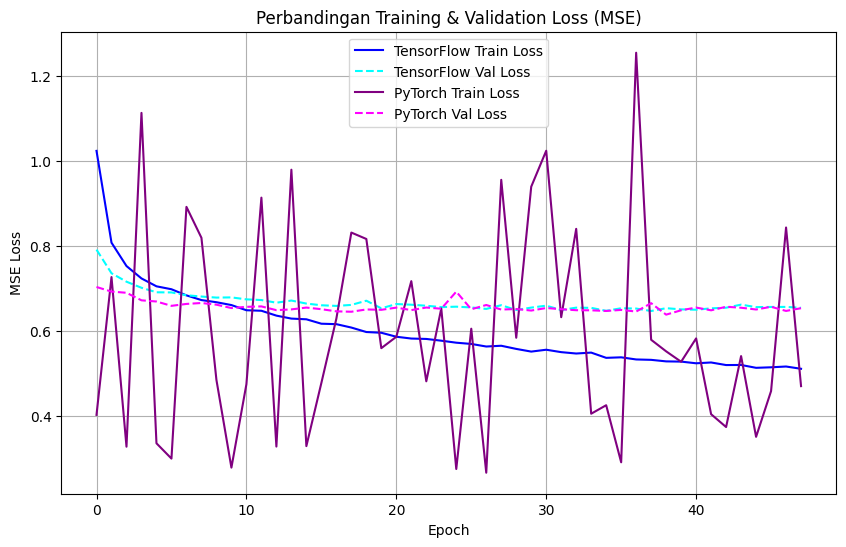

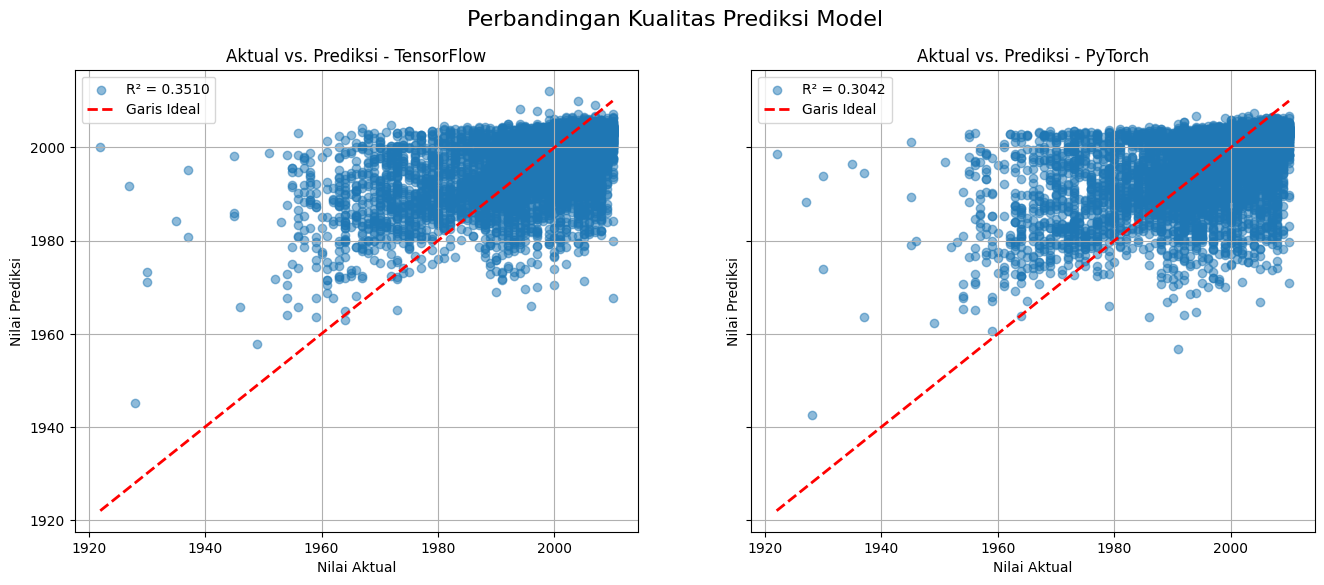

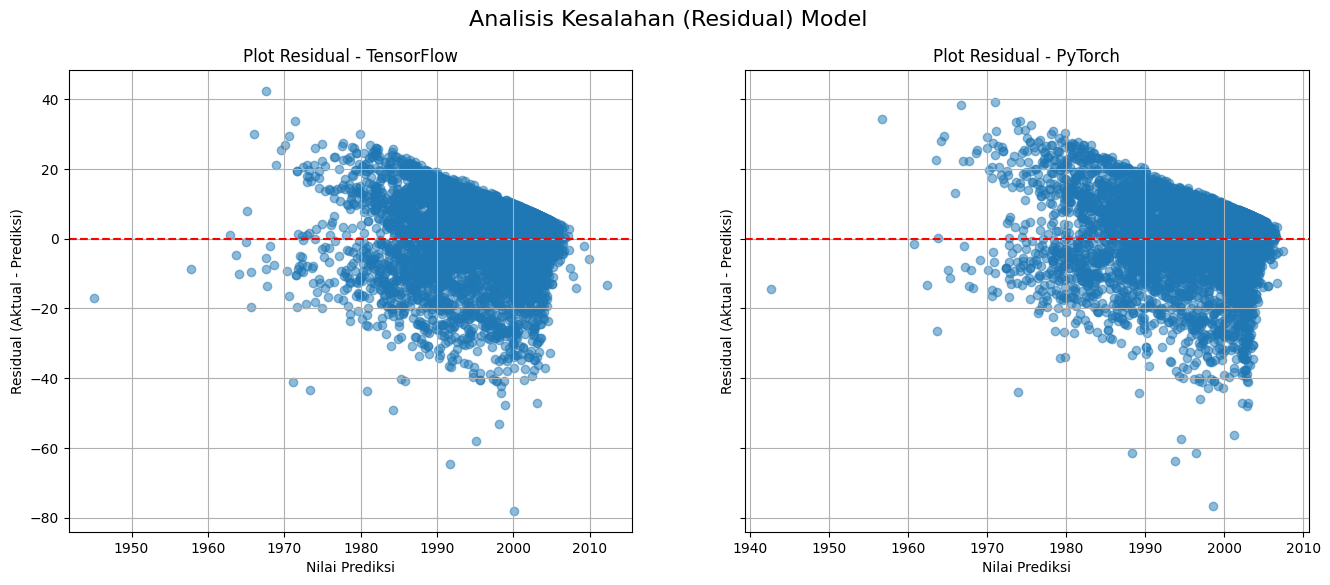

In [6]:
# --- 1. Persiapan Data ---
file_path = 'RegresiUTSTelkom.csv'
data_manager = DataManager(file_path, sample_frac=0.1) # Hanya gunakan 10% data

# --- 2. Model TensorFlow ---
print("🚀 Memulai Pelatihan & Evaluasi TensorFlow...")
X_train_tf, X_test_tf, y_train_tf_scaled, _ = data_manager.get_data(framework='tf')
tf_model = MLPTensorFlow(X_train_tf.shape[1])
history_tf = tf_model.train(X_train_tf, y_train_tf_scaled)
eval_tf = tf_model.evaluate(X_test_tf, data_manager.y_test, data_manager.y_scaler)

# --- 3. Model PyTorch ---
print("\n🔥 Memulai Pelatihan & Evaluasi PyTorch...")
X_train_torch, X_test_torch, y_train_torch_scaled, _ = data_manager.get_data(framework='torch')
pt_epochs = len(history_tf.epoch) # Samakan jumlah epoch dengan hasil early stopping TF
pt_model = MLPPyTorch(X_train_torch.shape[1])
history_pt = pt_model.train(X_train_torch, y_train_torch_scaled, epochs=pt_epochs)
eval_pt = pt_model.evaluate(X_test_torch, data_manager.y_test, data_manager.y_scaler)

# --- 4. Visualisasi Perbandingan ---
print("\n\n📊 Memvisualisasikan Hasil Perbandingan Model...")
plot_training_history(history_tf, history_pt, pt_epochs)

all_evals = {
    "TensorFlow": eval_tf,
    "PyTorch": eval_pt
}
plot_actual_vs_predicted(all_evals)
plot_residuals(all_evals)

# ==============================================================================
#                      ANALISIS AKHIR DAN KESIMPULAN
# ==============================================================================

"""
### 📌 Perbandingan Model MLP Regresi (Berdasarkan Hasil Eksekusi Terbaru)

1. 🧠 Penjelasan Setiap Model
-----------------------------
A. Model TensorFlow:
   - Menggunakan Keras API dengan arsitektur Sequential (128 -> 64 -> 32 -> 1 neuron).
   - Dilengkapi regularisasi BatchNormalization dan Dropout.
   - Menggunakan Early Stopping untuk efisiensi dan mencegah overfitting.

B. Model PyTorch:
   - Arsitektur identik dengan nn.Sequential.
   - Menggunakan BatchNorm1d, Dropout, dan inisialisasi bobot Kaiming.
   - Proses pelatihan telah disesuaikan dengan loop validasi untuk perbandingan yang adil.


2. 📊 Analisis Model Terbaik
-----------------------------
Hasil Evaluasi Kuantitatif:
- TensorFlow: MSE = 72.09, RMSE = 8.49, R² = 0.3510
- PyTorch   : MSE = 77.29, RMSE = 8.79, R² = 0.3042

Analisis Kualitatif:
- Metrik Error: Model TensorFlow secara konsisten menghasilkan error (MSE & RMSE) yang lebih rendah.
- Koefisien Determinasi (R²): Skor R² TensorFlow (0.3510) secara signifikan lebih tinggi,
  menunjukkan kemampuan model untuk menjelaskan variabilitas data yang lebih baik.
- Proses Pelatihan: Early Stopping pada TensorFlow terbukti efektif dalam menemukan epoch
  optimal secara otomatis (berhenti di epoch ke-48).


3. ✅ Kesimpulan Akhir
-----------------------------
Berdasarkan data evaluasi terbaru, **model yang dibangun menggunakan TensorFlow
adalah model terbaik** untuk tugas regresi ini.

Keunggulan utama model TensorFlow adalah:
1.  **Akurasi Prediksi Lebih Tinggi**: Terbukti dari nilai MSE dan RMSE yang lebih rendah.
2.  **Kekuatan Penjelasan Lebih Baik**: Memiliki skor R² yang lebih tinggi, yang krusial
    untuk memahami seberapa baik model menangkap pola dalam data.
3.  **Pelatihan Lebih Efisien**: Penggunaan Early Stopping membuat proses pelatihan lebih
    praktis dan optimal.

Meskipun model PyTorch juga kompeten, untuk hasil eksekusi ini, TensorFlow
memberikan solusi yang lebih akurat dan andal.

